In [1]:
import os
# use_cuda = False
use_cuda = True
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from torch.utils.data import TensorDataset, DataLoader
from helper import *
from utils import *
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from conceptshap import *
from text_helper import *
from pathlib import Path
from BERT_explainability.modules.BERT.ExplanationGenerator import Generator
from BERT_explainability.modules.BERT.BertForSequenceClassification import BertForSequenceClassification
from BERT_explainability.modules.BERT.ExplanationGenerator import Generator
from BERT_explainability.modules.layers_ours import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# ARGUMENTS
class args():
    def __init__(self):
        # DATA
        self.fast = 1000
#         self.fast = False
        self.max_features = 100000
        self.short_sentences = False

        # CLS model
#         self.model_name = 'bert' # could be 'lstm', 'bert' or 'cnn
        self.model_name = 'cnn' # could be 'lstm', 'bert' or 'cnn
        self.pretrained = True
        self.do_inference = False
        # pretrained = False
        # do_inference = True
        self.batch_size=128 #128
        self.epochs = 10 #30
        self.maxlen = 400
        self.embedding_dim = 100
        self.hidden_dim = 250 # actually unused, should delete

        # TOPIC MODEL
        # train_topic_model = True
        self.train_topic_model = False
        self.overall_method = 'two_stage' #could be 'conceptnet', 'conceptshap', 'cc', 'two_stage'
        self.n_concept = 10
        self.reg_0 = 50 #flip_loss
        self.reg_1 = 1 #pred_loss
        self.reg_2 = 0.1 #concept_sim
        self.reg_3 = 1 #concept_far
        self.reg_4 = 0 #consistency loss
        self.thres = 0.2

        # POST-HOC ANALYSIS
        self.eval_causal_effect = False
        self.interpret = False
        self.PDP = False
        self.gradcam = False
        self.dataset = 'news'
        self.dataset_cache_dir = "/data/ruochen/hf_datasets/"
        self.topk = 100
        self.visualize_most_common = False

In [4]:
args = args()
data = load_data_text(args)

Using custom data configuration default
Reusing dataset ag_news (/data/ruochen/hf_datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)



[0 1 2 3]
ids_train.shape:  (1000, 512)
y_train.shape:  (1000,)
1000 Training sequences
200 Validation sequences


In [7]:
from helper import *
# from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
args.save_dir = 'models/' + args.dataset + '/' + args.model_name +'/'
args.model_save_dir = 'models/' + args.dataset + '/' + args.model_name +'/cls_model.pkl'
# model = BertForSequenceClassification.from_pretrained(args.save_dir + 'imdb_weights').to(device)
# original_model = model
# model.eval() #put in eval mode
model = load_cls_model(args, device, data)

args.pretrained:  True
model loaded


In [10]:
# LOAD INFERENCE
args.layer_idx = -1
# tokenizer, (x_train, y_train), (x_val, y_val), (train_masks, val_masks) = data
(x_train, y_train), (x_val, y_val) = data
f_train, y_pred_train, f_val, y_pred_val = inference(data, model, device, args)

if args.fast:
    f_train = f_train[:args.fast]
    y_pred_train = y_pred_train[:args.fast]
    f_val = f_val[:int(args.fast*0.2)]
    y_pred_val = y_pred_val[:int(args.fast*0.2)]
# classifier = model.classifier
# print('classifier: ', classifier)
pred_val = y_pred_val.argmax(1).numpy()

f_train.shape:  torch.Size([120000, 10, 391])
f_val.shape:  torch.Size([7600, 10, 391])
y_pred_train.shape:  torch.Size([120000, 4])
y_pred_val.shape:  torch.Size([7600, 4])
inference results loaded!


In [12]:
args.graph_save_folder = args.save_dir + '{}/'.format(args.overall_method)
classifier = model.classifier
topic_model, topic_vector = load_topic_model(classifier, f_train, y_pred_train, f_val, y_pred_val, model, device, args, toy = (args.dataset=='toy'))
print('f_val.shape: ', f_val.shape)
print('y_val.shape: ', y_val.shape)

topic model loaded
training time elapsed:  0.03355860710144043
f_val.shape:  torch.Size([200, 10, 391])
y_val.shape:  (200,)


In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [28]:
stop_word_list = stop_word_list + ['[PAD]']

In [34]:
model.classifier.weight.shape

torch.Size([10, 10])

In [24]:
from BERT_explainability.modules.layers_ours import NormLayer
# write the topic model to a sequential classifier
linearlayer1 = Linear(768, args.n_concept, bias = False)
topic_vector_n = F.normalize(topic_model.topic_vector, dim = 0, p=2).transpose(1,0)
linearlayer1.weight = nn.Parameter(topic_vector_n)

thres = topic_model.thres
print('thres: ', thres)

linearlayer2 = Linear(args.n_concept, args.n_concept, bias = True)
linearlayer2.weight = nn.Parameter(torch.eye(args.n_concept), requires_grad=False)
linearlayer2.bias = nn.Parameter(torch.ones(args.n_concept)*(-thres), requires_grad = False)

linearlayer3 = Linear(topic_model.rec_vector_1.shape[0], topic_model.rec_vector_1.shape[1], bias = False)
linearlayer3.weight = nn.Parameter(topic_model.rec_vector_1.transpose(1,0))
new_cut_classifier = Sequential(NormLayer(),
                           linearlayer1,
                            linearlayer2,
                            ReLU(),
                           NormLayer()).to(device)
model.classifier = new_cut_classifier

# initialize the explanations generator
explanations = Generator(model)

thres:  0.3


In [14]:
f_train = f_train.to(device)
y_train = torch.from_numpy(y_train).to(device)
with torch.no_grad():
    _, _, _, _, topic_prob_n = topic_model(f_train, 'conceptshap', y_train)
print('topic_prob_n.shape: ', topic_prob_n.shape)

topic_prob_n.shape:  torch.Size([1000, 10])


In [26]:
def get_exp(i, x_val, y_val, val_mask, t, tokenizer, device, model, explanations):
    x=x_val[i]
    y=y_val[i]
    input_ids = torch.from_numpy(x).unsqueeze(0).to(device)
    attention_mask = val_mask[i].unsqueeze(0).to(device)
    # true class is positive - 1
    true_class = y
    output = model(input_ids=input_ids, attention_mask=attention_mask)[0]
    expl = explanations.generate_LRP(input_ids=input_ids, attention_mask=attention_mask, start_layer=0, index = t)[0]
    # normalize scores
    expl = (expl - expl.min()) / (expl.max() - expl.min())
    tokens = tokenizer.convert_ids_to_tokens(input_ids.flatten())
    return expl, tokens
def only_letters(z):
    return z.isalpha()

Doing topic 0!


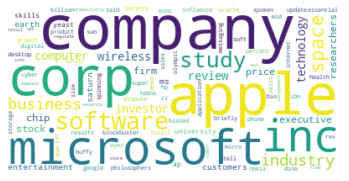

In [28]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

sw = stopwords.words('english') + ['[CLS]', '[UNK]', '[PAD]']
write = ''
# for i in range(topic_prob_n.shape[1]):
i = 0
print(f'Doing topic {i}!')
write += f'Topic {i} \n'
words = []
topic_prob = topic_prob_n[:, i].cpu().detach().numpy()
topk = topic_prob.argsort()[::-1][:args.topk]
for j in topk:
    prob = topic_prob[j]
    # only take ones with probabilities greater than 0.7
    if args.visualize_most_common:
        tokens = tokenizer.convert_ids_to_tokens(x_train[j].flatten())
        words += tokens
    else:
        exp, tokens = get_exp(j, x_train, y_train, train_masks, i, tokenizer, device, model, explanations)
        exp = exp.cpu().detach().numpy()
        valid = np.where(exp>0.7)[0]
        valid = [tokens[v] for v in valid]
        words += valid
words = [w for w in words if w not in sw]
words = [w for w in words if only_letters(w)]
# cx = Counter(words)
# most_occur = cx.most_common(50)
# most_occur = [mo[0] for mo in most_occur]
# write += ','.join(most_occur) + '\n'
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='white').generate(' '.join(words))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
model = BertForSequenceClassification.from_pretrained(args.save_dir + 'imdb_weights').to(device)